Lim Nan Hang 190704D

# Introduction

Object Detection is used to detect doors and stairs to help the blind to navigate easier while travelling

# Data Collection

Door dataset (images containing only door) was obtained from https://github.com/gasparramoa/DeepDoors2

Stairs dataset (images containing only stairs) was obtained from http://enorasi.dib.uth.gr/database/index.html

Door + Stairs (images containing both door and stairs) dataset images are collated from Unsplash, Flickr, Pexels, and Google

# Data Preparation

1. Resized images to fit to pretrained model's input size

2. Removed images that do not match label (e.g. escalator in stairs dataset)

3. Rename label for stairs dataset (upstairs and downstairs to stairs)

4. Labelled images using labelImg
- Most of the stairs images are prelabelled
- Drew additional bounding boxes for stairs (image shows multiple stairs, but only one bounding box was prelabelled)

5. Partition dataset into train and test using code from https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/d0e545609c5f7f49f39abc7b6a38cec3/partition_dataset.py

6. Created tfrecord for train and test using code from https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py


In [ ]:
# code for resizing images

import glob, os
from PIL import Image

os.chdir("img_dir")
fileList = os.listdir()

for fileName in glob.glob("*.jpg"):
    image = Image.open(fileName)
    image.thumbnail((500, 500))
    image.save(fileName)

In [ ]:
# code for renaming labels (for images with only one bounding box)

import glob, os
import xml.etree.ElementTree as ET

os.chdir("annotations_dir")
fileList = os.listdir()

for fileName in glob.glob("*.xml"):
    xmlTree = ET.parse(fileName)
    rootElement = xmlTree.getroot()
    objectElement = rootElement.find("object")
    nameElement = objectElement.find("name")
    nameElement.text = "stairs"
    xmlTree.write(fileName, encoding='UTF-8', xml_declaration=True)

# Model Training and Experiments

Choosing pretrained model
- Pretrained model should be small enough to be used in a mobile phone
- Pretrained model should be fast in detection
- Pretrained model should have good mAP

Candidate: EfficientDet D0 (20.4 MB for saved_model.pb, speed 39ms, 33.6 mAP)

Edited model's pipeline.config to add additional data augmentation (availble in run3 directory for reference)

## trained by running train.sh in terminal, below is the copied output

## evaluation results in tensorboard

![eval_charts.png](eval_charts.png "eval charts")

![eval_images.png](eval_images.png "eval images")

### from the above chart, we can see that the mAP@0.5IOU is about 0.85

# Testing with unseen dataset

In [15]:
# load model
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = "run3/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 42.449697732925415 seconds


In [5]:
# load label map for plotting
category_index = label_map_util.create_category_index_from_labelmap('label_map.pbtxt', use_display_name=True)

In [8]:
%matplotlib inline

Running inference for door1.jpg... Done
Running inference for door2.jpg... Done
Running inference for stairs1.jpg... Done
Running inference for stairs2.jpg... Done
Running inference for door+stairs1.jpg... Done
Running inference for door+stairs2.jpg... Done


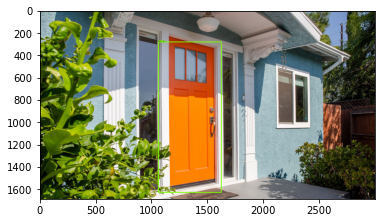

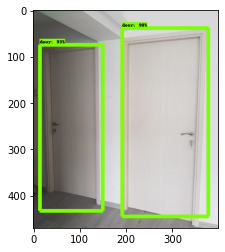

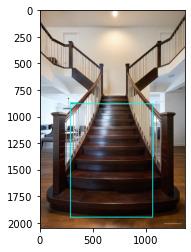

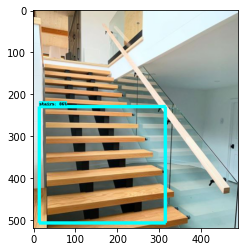

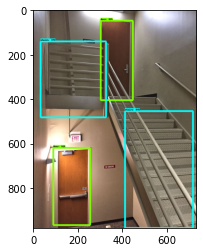

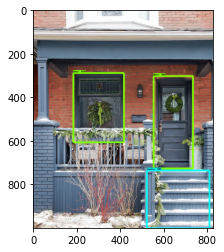

In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

IMAGE_PATHS = ['door1.jpg', 'door2.jpg', 'stairs1.jpg', 'stairs2.jpg', 'door+stairs1.jpg', 'door+stairs2.jpg']

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          line_thickness=8,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()